In [1]:
#needed imports

import sklearn
from sklearn import decomposition
import torchfile
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import os
from shutil import copyfile
import binascii
from sklearn.mixture import GaussianMixture
import random
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load whole dataset

dataset = torchfile.load('DatasetFeatures.t7')
print (dataset.features.shape)

(6889, 2048)


In [3]:
pca = decomposition.PCA(n_components=1000, svd_solver='full')
pca.fit(dataset.features)

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [4]:
transformed_data = pca.transform(dataset.features)

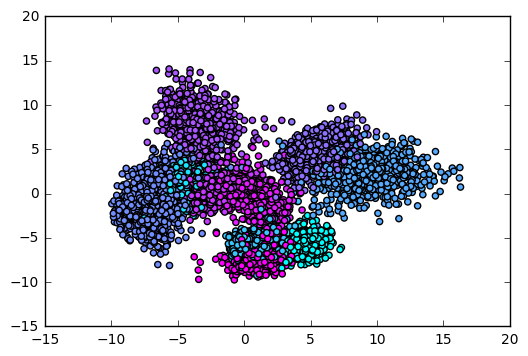

In [5]:
km = KMeans(n_clusters=10)
km.fit(transformed_data[0:2000])

plt.figure()
plt.scatter(transformed_data[:,0], transformed_data[:,1], c=km.predict(transformed_data), cmap=plt.get_cmap("cool"), s=20)
plt.show()

In [6]:
axis = range(8,20,1)
Js = []

import numpy as np
from numpy import random

random.shuffle(transformed_data)

print ("K"," " "criterion value")
for K in range(8, 20):
    kmean = KMeans(n_clusters=K)
    kmean.fit(transformed_data)
    
    Js.append(kmean.inertia_)
    print(K, " ", kmean.inertia_)

plt.plot(axis, Js, color = "red")
plt.show()

('K', ' criterion value')
(8, ' ', 1009213.6812633558)
(9, ' ', 961087.22145869141)
(10, ' ', 910712.62446303293)
(11, ' ', 893304.03844921163)
(12, ' ', 884854.83417018491)


KeyboardInterrupt: 

In [15]:
n_clusters = 10 

transformed_data_unshuffled = pca.transform(dataset.features)

for i in range(n_clusters):
    newpath = r'./class_' + str(i)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
clusterer = GaussianMixture(n_components=n_clusters, random_state=12)
clusterer.fit(transformed_data_unshuffled)

for i in range(len(dataset.image_list)):
    path = dataset.image_list[i]
    
    feature_vec = transformed_data_unshuffled[i]
    class_val = clusterer.predict(feature_vec)
    save_path = r'./class_' + str(class_val[0])
    tokens = path.decode("utf-8").split('/')
    try:
        copyfile(path.decode("utf-8"), save_path + '/' + tokens[len(tokens) - 1])
    except FileNotFoundError:
        last = tokens[len(tokens) - 1]
        last=last.replace('.png', '.jpg')
        copyfile(path.decode("utf-8").replace('.png', '.jpg'), save_path + '/' + last)
        


('For n_clusters =', 10, 'The average silhouette_score is :', 0.23725353432838256)


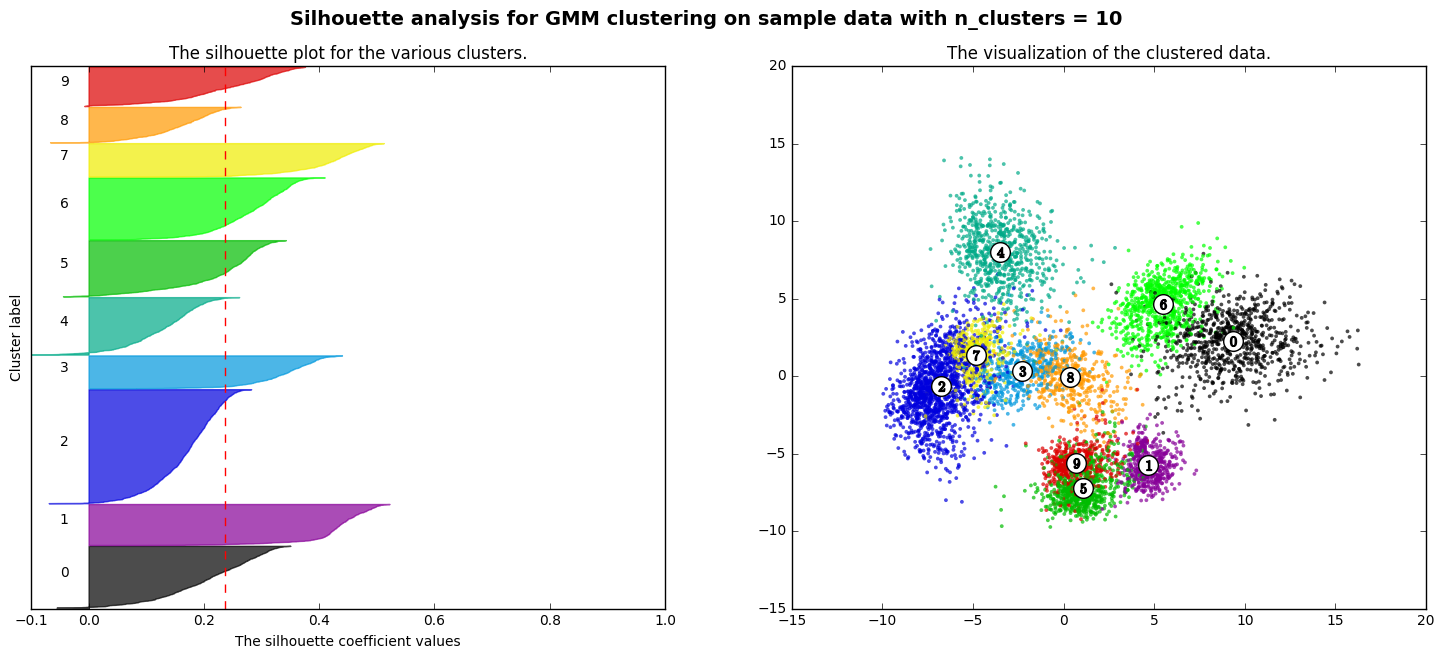

In [16]:
range_n_clusters = range(10, 11, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(transformed_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = GaussianMixture(n_components=n_clusters)
    #clusterer.fit(transformed_data)
    cluster_labels = clusterer.predict(transformed_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(transformed_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(transformed_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(transformed_data[:, 0], transformed_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.means_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    
    plt.suptitle(("Silhouette analysis for GMM clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [ ]:
##OVO KORISTI FRANJO -- NOT NEEDED FOR MOZGALo
"""
n_clusters = 14 # found to be the best for 627 features

transformed_data_unshuffled = pca.transform(dataset.features)

random.shuffle(transformed_data)

for i in range(n_clusters):
    newpath = r'./class_' + str(i)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
clusterer = KMeans(n_clusters=n_clusters)
clusterer.fit(transformed_data)


closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, transformed_data)
print (closest)
for i in range(len(dataset.image_list)):
    path = dataset.image_list[i]
    
    feature_vec = transformed_data_unshuffled[i]
    class_val = clusterer.predict(feature_vec)
    save_path = r'./class_' + str(class_val[0])
    #print (path)
    #path = binascii.a2b_uu(path)
    #print (path.decode("utf-8"))
    tokens = path.decode("utf-8").split('/')
    print (tokens)
    try:
        copyfile(path.decode("utf-8"), save_path + '/' + tokens[len(tokens) - 1])
    except FileNotFoundError:
        last = tokens[len(tokens) - 1]
        print (last)
        last=last.replace('.png', '.jpg')
        print (last)
        #last[:-4]='.jpg'
        copyfile(path.decode("utf-8").replace('.png', '.jpg'), save_path + '/' + last)
        
"""

In [188]:
def get_n_nearest_per_centroid(clusterer, n, torch_dataset):
    data_per_class = []
    data = pca.transform(torch_dataset.features)
    image_names = np.asarray(torch_dataset.image_list)
    np.matrix(image_names)
    predictions = clusterer.predict(data)
    data_with_probs = np.c_[image_names, predictions]
    data_with_probs = np.c_[data_with_probs, clusterer.score_samples(data)[:]]
    #print 'shape', data_with_probs.shape
    #data_with_probs.sort()
    data_with_probs = sorted(data_with_probs, key=lambda e: e[-1]) 
    
    #print 'data', data_with_probs
    
    clusters = set(predictions)
    
    ct_clusters = len(clusters)
    #print 'ct_clusters', ct_clusters
    for cluster in range(ct_clusters):
        #print np.where(data_with_probs[:] == str(cluster))
        indices = np.where(np.array(data_with_probs)[:,1] == str(cluster))
        #print 'cluster', cluster
        indices = indices[0]
        #print 'indices', indices
        data_per_class.append([])
        for i in range(n):
            data_per_class[cluster].append(data_with_probs[indices[i]])
    return data_per_class

In [212]:
nearest = get_n_nearest_per_centroid(clusterer, 10, dataset)

In [198]:
print nearest[0][0]

['../Dataset/dataset/1192.jpg' '0' '1956.6352779']


In [215]:
import subprocess

for cluster_representants in nearest:
    print 'cluster', cluster_representants[0][1]
    for representant in cluster_representants:
        classifier = '../../resnet/fb.resnet.torch/pretrained/classify.lua'
        resnet = '../../resnet/resnet-200.t7'
        image = representant[0]
        #print os.path.isfile(image) 
        print subprocess.check_output(['th', classifier, resnet, image]) 
#])

cluster 0
Found Environment variable CUDNN_PATH = /usr/local/cuda/lib64/libcudnn.so.5	
Classes for	../Dataset/dataset/1192.jpg	
0.26438674330711	plate rack	
0.1655760705471	airliner	
0.034430202096701	pool table, billiard table, snooker table	
0.031642027199268	isopod	
0.028641464188695	letter opener, paper knife, paperknife	
	

Found Environment variable CUDNN_PATH = /usr/local/cuda/lib64/libcudnn.so.5	
Classes for	../Dataset/dataset/2344.jpg	
0.36945250630379	hair slide	
0.3460148870945	letter opener, paper knife, paperknife	
0.028240172192454	buckle	
0.027221709489822	fountain pen	
0.02391622774303	bolo tie, bolo, bola tie, bola	
	

Found Environment variable CUDNN_PATH = /usr/local/cuda/lib64/libcudnn.so.5	
Classes for	../Dataset/dataset/1395.jpg	
0.4442865550518	space bar	
0.28535827994347	typewriter keyboard	
0.11042167246342	revolver, six-gun, six-shooter	
0.023648740723729	cornet, horn, trumpet, trump	
0.021000493317842	cassette player	
	

Found Environment variable CUDNN_PATH 